# Proyecto STS

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn

In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [4]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

In [5]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from nltk.corpus import stopwords

In [6]:
import re
from sklearn.model_selection import train_test_split

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\usuario.DESKTOP-
[nltk_data]     GDR7TES\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
torch.manual_seed(777) # seed para reproductibilidad

**Lectura de datos.** Dado que en este caso nuestros datos vienen en texto, necesitaremos realizar un 
proceso diferente para obtener los datos.

In [21]:
train_df= pd.read_csv('train.csv')
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [22]:
train_df['question1'].iloc[10]

'Method to find separation of slits using fresnel biprism?'

## Preprocesamiento

### Separación de las preguntas en tokens

La siguiente función es parte del preprocesamiento. Vamos a convertir cada oración en una lista de palabras, y vamos a homogenizar contracciones comunes de palabras en ingles (ya que las preguntas están en inglés).

In [11]:
stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

Tenemos que hacer lo siguiente: Para cada dataset, agregar las columnas `question1_vec` y `question2_vec`. Estas columnas contienen la respresentación de las preguntas como listas de embeddings, donde cada embedding (vector) corresponde a una de las palabras (tokens) de la pregunta.

Para hacer esto, primero pasaremos cada pregunta por la función `text_to_word_list`, obteniendo la lista de tokens que le corresponden. En esta función se homogenizan algunas contracciones comunes.

El resultado de pasar nuestar pregunta por `text_to_word_list` lo agregaremos al dataframe como una columna `question1_tokens` o `question2_tokens`.

Luego, por cada lista de tokens, usaremos un modelo pre-entrenado de Word2Vec para asignarle un vector a cada palabra de la lista. Estas listas de vectores las guardaremos en las columnas `question1_vec` y `question2_vec`.

Estas listas de vectores serán la entrada de nuestro modelo más adelante.

In [23]:
# training dataset:
train_question1_tokens = [text_to_word_list(q) for q in train_df['question1']]
train_df['question1_tokens'] = train_question1_tokens

train_question2_tokens = [text_to_word_list(q) for q in train_df['question2']]
train_df['question2_tokens'] = train_question2_tokens

Ahora nuestro dataframe de entrenamiento tiene las columas extra:

In [24]:
train_df[['question1', 'question1_tokens', 'question2', 'question2_tokens']].head()

,question1,question1_tokens,question2,question2_tokens
0,What is the step by step guide to invest in sh...,"[what, is, the, step, by, step, guide, to, inv...",What is the step by step guide to invest in sh...,"[what, is, the, step, by, step, guide, to, inv..."
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,"[what, is, the, story, of, kohinoor, koh, -, i...",What would happen if the Indian government sto...,"[what, would, happen, if, the, indian, governm..."
2,How can I increase the speed of my internet co...,"[how, can, i, increase, the, speed, of, my, in...",How can Internet speed be increased by hacking...,"[how, can, internet, speed, be, increased, by,..."
3,Why am I mentally very lonely? How can I solve...,"[why, am, i, mentally, very, lonely, how, can,...",Find the remainder when [math]23^{24}[/math] i...,"[find, the, remainder, when, math, 23, ^, 24, ..."
4,"Which one dissolve in water quikly sugar, salt...","[which, one, dissolve, in, water, quikly, suga...",Which fish would survive in salt water?,"[which, fish, would, survive, in, salt, water]"


Usamos solo las filas que **no** tengan más de 30 tokens en sus preguntas. Esto es sólo para que el entrenamiento no sea tan pesado.

In [25]:
# Función para checar si la longitud de question1_tokens y question2_tokens es menor o igual a 30
def check_length(row):
    if len(row['question1_tokens']) > 15 or len(row['question2_tokens']) > 15:
        return False
    return True

# Aplicar la función check_length para filtrar el dataframe
train_df = train_df[train_df.apply(lambda row: check_length(row), axis=1)]

# Vemos cuántos ejemplares quedaron:
len(train_df)

300185

In [28]:
train_df['question1'].iloc[777]

'Do you think of mathematics as art or science?'

In [29]:
# Usamos menos ejemplares de los que hay disponibles porque mi computadora no tiene mucha memoria
train_df = train_df.sample(n=100000)

### Agregar embeddings de Word2Vec

Ahora tranformamos las listas de tokens a arreglos de numpy con su representación en vectores. Agregamos esas columnas al dataframe.

Usaremos un modelo pre-entrenado de Word2Vec.

In [30]:
from gensim.models import KeyedVectors

# Cargamos el modelo pre-entrenado de word2vec
model_file = "w2v_model/google_news_word2vec.model"
word2vec = KeyedVectors.load(model_file)

In [31]:
def get_vector(token):
    try:
        return word2vec[token]
    except KeyError:
        return None

def tokens_to_vectors(token_list):
    # si la palabra no existe en el vocabulario de word2vec, sólo la saltamos
    vector_list = [vector for token in token_list if (vector := get_vector(token)) is not None]
    if len(vector_list) > 0:
        return vector_list
    return None

In [32]:
# training dataset:
train_question1_vectors = [tokens_to_vectors(tk) for tk in train_df['question1_tokens']]
train_df['question1_vectors'] = train_question1_vectors

train_question2_vectors = [tokens_to_vectors(tk) for tk in train_df['question2_tokens']]
train_df['question2_vectors'] = train_question2_vectors

In [33]:
# Ahora eliminaremos las filas con algún valor None
print('Before dropping rows with missing values:', len(train_df['question1_vectors']))
train_df.dropna(inplace=True)
print('After dropping rows with missing values:', len(train_df['question1_vectors']))

Before dropping rows with missing values: 90000
After dropping rows with missing values: 89992


In [34]:
train_df[['question1', 'question1_vectors', 'question2', 'question2_vectors']].head()

,question1,question1_vectors,question2,question2_vectors
158843,How do I delete a question from Quora?,"[[0.26953125, 0.0859375, 0.09423828, 0.0410156...",How can you delete a question that you asked o...,"[[0.26953125, 0.0859375, 0.09423828, 0.0410156..."
118337,Why is phenol more acidic than ethanol?,"[[0.15136719, 0.012451172, 0.21777344, 0.03039...",Why is hydroquinone more acidic than phenol?,"[[0.15136719, 0.012451172, 0.21777344, 0.03039..."
81829,What are the best comments that we share on a ...,"[[0.13964844, -0.006164551, 0.21484375, 0.0727...",How can I steal a girl's heart and impress her?,"[[0.26953125, 0.0859375, 0.09423828, 0.0410156..."
218195,What should I do in free time?,"[[0.13964844, -0.006164551, 0.21484375, 0.0727...",What do you do when you got free time?,"[[0.13964844, -0.006164551, 0.21484375, 0.0727..."
70427,What are some of the best science fiction nove...,"[[0.13964844, -0.006164551, 0.21484375, 0.0727...",What are the best science fiction novels?,"[[0.13964844, -0.006164551, 0.21484375, 0.0727..."


Vamos a guardar por aquí la longitud máxima de la lista de tokens para ambas preguntas.

In [35]:
max_length_question1 = train_df['question1_tokens'].apply(lambda x: len(x)).max()
max_length_question2 = train_df['question2_tokens'].apply(lambda x: len(x)).max()
max_length_question = max_length_question1 if max_length_question1 >= max_length_question2 else max_length_question2
max_length_question

15

### Crear conjuntos de entrenamiento y prueba, y prepararlos para el dataloader

Se define una función para transformar las columnas de los conjuntos a listas de tensores, para que puedan ser usados en el dataloader.

También se define una función para agregarle padding a las secuencias, para que todas sean del mismo tamaño (los espacios extras se llenan con 0s).

In [36]:
def embedded_vectors_to_tensors(question1_vectors, question2_vectors):
    # Cambiamos los conjuntos a un diccionario y los transformamos en
    # arreglos de numpy
    X = {
        'question1': [np.array(vecs) for vecs in question1_vectors],
        'question2': [np.array(vecs) for vecs in question2_vectors]
    }
    # Ahora, transformamos las listas de las columnas de vectores en listas de tensores.
    X = {
        'question1': [torch.tensor(np_vecs) for np_vecs in X['question1']],
        'question2': [torch.tensor(np_vecs) for np_vecs in X['question2']]
    }
    return X

In [42]:
"""
Recibe una lista de (# de ejemplares) tensores de tamaño [max_sequence_length, word_vectors_length].
Regresa un tensor de tamaño [# de ejemplares, max_sequence_length, word_vectors_length], con todos
sus tensores de tamaño max_sequence_length con 0s en los espacios donde originalmente no había nada (padding).
(Checa torch.nn.utils.rnn.pad_sequence)
"""
def tensorize_and_pad_sequences(sequences, max_sequence_length, word_vectors_length):
    batch_size = 500  # Adjust the batch size as per your memory constraints
    num_batches = (len(sequences) + batch_size - 1) // batch_size

    dummy_tensor = torch.ones(max_sequence_length, word_vectors_length)

    padded_sequences = []
    for i in range(num_batches):
        if i % 10 == 0:
            print('batch: ',i)
        batch = sequences[i * batch_size : (i + 1) * batch_size]
        num_rows = len(batch)
        batch.append(dummy_tensor)
        padded_batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True)
        padded_batch = torch.index_select(padded_batch, 0, torch.arange(num_rows))
        padded_sequences.append(padded_batch)

    return torch.cat(padded_sequences, dim=0)  # Concatenate the batches

Por último, se crea una función que recibe un dataframe, y regresa un diccionario X con un tensor para cada pregunta (question1 y question2) y uno para targets.

In [38]:
word_vectors_length = 300

def prepare_sample_df_for_dataloader(question1_vectors, question2_vectors, targets):    
    X = embedded_vectors_to_tensors(question1_vectors, question2_vectors)
    X['question1'] = tensorize_and_pad_sequences(X['question1'], max_length_question, word_vectors_length)
    X['question2'] = tensorize_and_pad_sequences(X['question2'], max_length_question, word_vectors_length)
    
    targets = targets.values.tolist()
    targets = torch.tensor(targets)
    
    print('size q1:', X['question1'].size()) # X.question1 tiene tamaño (NUM_EJEMPLARES, MAX_SENT_LEN, EMBEDDING_DIM).
    print('size q2:', X['question2'].size())
    print('size targets:', targets.size())
    
    return X, targets

Separación de los conjuntos de entrenamiento y prueba.

In [43]:
X = train_df[['question1_vectors', 'question2_vectors']]
Y = train_df['is_duplicate']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Creación del DataLoader

Creo un DataSet y DataLoader para el conjunto de entrenamiento y de prueba.

In [44]:
BATCH_SIZE = 64

In [45]:
class QuestionsDataset(Dataset):
    def __init__(self, question1, question2, targets):
        self.question1 = question1
        self.question2 = question2
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        question1 = self.question1[index]
        question2 = self.question2[index]
        isDuplicate = self.targets[index]

        return question1, question2, isDuplicate

In [46]:
# El resultado de prepare_sample_df_for_dataloader lo podemos convertir a un QuestionsDataset para ingresarlo en el dataloader

X, targets = prepare_sample_df_for_dataloader(X_train.question1_vectors, X_train.question2_vectors, Y_train)
dataset_train = QuestionsDataset(X['question1'], X['question2'], targets)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

batch:  0
batch:  10
batch:  20
batch:  30
batch:  40
batch:  50
batch:  60
batch:  70
batch:  80
batch:  90
batch:  100
batch:  110
batch:  120
batch:  0
batch:  10
batch:  20
batch:  30
batch:  40
batch:  50
batch:  60
batch:  70
batch:  80
batch:  90
batch:  100
batch:  110
batch:  120
size q1: torch.Size([60294, 15, 300])
size q2: torch.Size([60294, 15, 300])
size targets: torch.Size([60294])


In [47]:
# vemos que el tamaño sea correcto
question1_batch, question2_batch, isDuplicate_batch = next(iter(dataloader_train))
question1_batch.size()

torch.Size([64, 15, 300])

## Definición del modelo
Una vez que se tienen las entradas, el modelo necesita 3 cosas: el codificador posicional, el encoder del transformador, y una función de similitud entre dos vectores (las salidas del encoder del transformador). Estas tres cosas las vamos a integrar en una red neuronal siamesa.

### Codificación posicional
Se les aplica una codificación posicional a las secuencias de embeddings, para tomar en cuenta el orden de las secuencias.

En el paper original por Vaswani et al., la matriz para codificar la posición se obtenía con las siguientes fórmulas:
$$
PE(\text{position}, 2i) = \sin\bigg( \frac{ \text{position} }{10000^\frac{2i}{d}} \bigg)
$$

$$
PE(\text{position}, 2i+1) = \cos\bigg( \frac{ \text{position} }{10000^\frac{2i}{d}} \bigg)
$$

donde *d* es la dimensión de los vectores de los tokens.

Para hacer la codificación posicional se crea una clase PositionalEncoding. 

In [48]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model

        # Create the positional encoding matrix
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add the positional encoding to the input
        x = x + self.pe[:, :x.size(1)]
        return x

In [49]:
positionalEncoder = PositionalEncoding(word_vectors_length, max_seq_len = max_length_question)
question1_batch = positionalEncoder(question1_batch)
print(question1_batch.shape)              # (BATCH_SIZE, SEQ_LEN, EMBEDDING_DIM)

torch.Size([64, 15, 300])


### El encoder del transformador

In [50]:
EMBEDDING_DIM = word_vectors_length
HIDDEN_SIZE = 16
NUM_HEADS = 5
DROPOUT = .3

enc_layer = nn.TransformerEncoderLayer(EMBEDDING_DIM, NUM_HEADS, HIDDEN_SIZE, DROPOUT, batch_first=True)
encoder_result = enc_layer(question1_batch)
print(encoder_result.shape)

torch.Size([64, 15, 300])


### Pooling
En el paper de SBERT usan mean pooling.

In [51]:
one_encoder_result = encoder_result

In [52]:
poolingLayer = nn.AvgPool2d(kernel_size=(1, word_vectors_length), stride=(1, word_vectors_length))
output = poolingLayer(one_encoder_result)

In [53]:
output.size()

torch.Size([64, 15, 1])

### La función de similitud
En el paper de SBERT usan cosine similarity.

### Construcción de la red siamesa
La red va a tener un encoder de transformador en cada lado, y los vectores resultantes se van a comparar con cosine_similarity ???

// Mostrar una imagen de la arquitectura

In [54]:
EMBEDDING_DIM = word_vectors_length
HIDDEN_SIZE = 32
NUM_HEADS = 5
DROPOUT = .1

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Positional Encodder
        self.positionalEncoder = PositionalEncoding(word_vectors_length, max_seq_len = max_length_question)

        # Capas de encoders de transformadores
        self.transformer_encoder_1 = nn.TransformerEncoderLayer(EMBEDDING_DIM, NUM_HEADS, HIDDEN_SIZE, DROPOUT, batch_first=True)
        self.transformer_encoder_2 = nn.TransformerEncoderLayer(EMBEDDING_DIM, NUM_HEADS, HIDDEN_SIZE, DROPOUT, batch_first=True)
        self.transformer_encoder_3 = nn.TransformerEncoderLayer(EMBEDDING_DIM, NUM_HEADS, HIDDEN_SIZE, DROPOUT, batch_first=True)
        self.transformer_encoder_4 = nn.TransformerEncoderLayer(EMBEDDING_DIM, NUM_HEADS, HIDDEN_SIZE, DROPOUT, batch_first=True)
        

        # Mean Pooling
        self.avg_pool = nn.AvgPool2d(kernel_size=(1, word_vectors_length), stride=(1, word_vectors_length))

        # Cosine Similarity
        self.cos_similarity = nn.CosineSimilarity(dim=1)

    def forward(self, input1, input2):
        # Pasamos la pregunta 1:
        input1 = self.positionalEncoder(input1)
        output1 = self.transformer_encoder_1(input1)
        output1 = self.transformer_encoder_2(input1)
        output1 = self.transformer_encoder_3(input1)
        output1 = self.transformer_encoder_4(input1)
        output1 = self.avg_pool(output1)
        output1 = torch.flatten(output1, start_dim=1)
        
        # Pasamos la pregunta 2:
        input2 = self.positionalEncoder(input2)
        output2 = self.transformer_encoder_1(input2)
        output2 = self.transformer_encoder_2(input2)
        output2 = self.transformer_encoder_3(input2)
        output2 = self.transformer_encoder_4(input2)
        output2 = self.avg_pool(output2)
        output2 = torch.flatten(output2, start_dim=1)

        # Compute Cosine Similarity
        similarity = self.cos_similarity(output1, output2)

        return similarity

## Entrenamiento
En el paper de SBERT usan  batch-size of 16, Adam optimizer with
learning rate 2e−5, and a linear learning rate
warm-up over 10% of the training data.

In [65]:
# Define the MSE loss function
criterion = nn.MSELoss()

# Define the optimizer
learning_rate = 0.0001

def train(dataloader, model, epochs):
    print("::: Iniciando entrenamiento... :::")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    all_losses = []
    for epoch in range(epochs):
        loss = 0
        batch_number = 0
        for data in dataloader:
            input1, input2, target_similarity = data
            optimizer.zero_grad()
            output_similarity = model(input1, input2)
            # Convertir target_similarity al mismo tipo de dato que output_similarity
            target_similarity = target_similarity.to(output_similarity.dtype)
            loss = criterion(output_similarity, target_similarity)

            loss.backward()
            optimizer.step()
            
            if batch_num % 100 == 0:
                all_losses.append(loss.item())
            if batch_num % 200 == 0:
                print(f"Batch number:: {batch_num}")
            batch_number = batch_number + 1

        print(f"Epoch {epoch}, Loss: {loss.item()}")
        
    print("::: ...Fin del entrenamiento :::")
    return all_losses

Vamos a crear un modelo llamado *modelo* (por quora question pairs). Y vamos a ir entrenando por separado cada epoch. Después de entrenar un epoc vamos a ir guardando el modelo en la dirección especificada. Esto para no perder el progreso del entrenamiento si se  acaba la memoria.

In [57]:
# Creamos el modelo
modelo = SiameseNetwork()

In [67]:
# Entrenamos un epoch
losses = train(dataloader_train, modelo, 10)

::: Iniciando entrenamiento... :::
Epoch 0, Loss: 0.2649436295032501
Epoch 1, Loss: 0.21263937652111053
Epoch 2, Loss: 0.2590460181236267
Epoch 3, Loss: 0.21791104972362518
Epoch 4, Loss: 0.2085525244474411
Epoch 5, Loss: 0.21562479436397552
Epoch 6, Loss: 0.2957985997200012
Epoch 7, Loss: 0.21295708417892456
Epoch 8, Loss: 0.18642425537109375
Epoch 9, Loss: 0.22216437757015228
::: ...Fin del entrenamiento :::


In [ ]:
# Guardamos
torch.save(modelo.state_dict(), "modelo_qqp.pt")

In [84]:
# Con el conjunto de prueba
X, targets = prepare_sample_df_for_dataloader(X_test.question1_vectors, X_test.question2_vectors, Y_test)
dataset_test = QuestionsDataset(X['question1'], X['question2'], targets)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=True)
question1_batch, question2_batch, isDuplicate_batch = next(iter(dataloader_test))

predicted_similarity = modelo(question1_batch, question2_batch)

batch:  0
batch:  10
batch:  20
batch:  30
batch:  40
batch:  50
batch:  0
batch:  10
batch:  20
batch:  30
batch:  40
batch:  50
size q1: torch.Size([29698, 15, 300])
size q2: torch.Size([29698, 15, 300])
size targets: torch.Size([29698])


RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 534564000 bytes.

In [82]:
from sklearn.metrics import accuracy_score
predicted_similarity = predicted_similarity.detach()
predicted_similarity = torch.where(predicted_similarity > 0.7, 1, 0)
accuracy_score(isDuplicate_batch, predicted_similarity)

0.5625

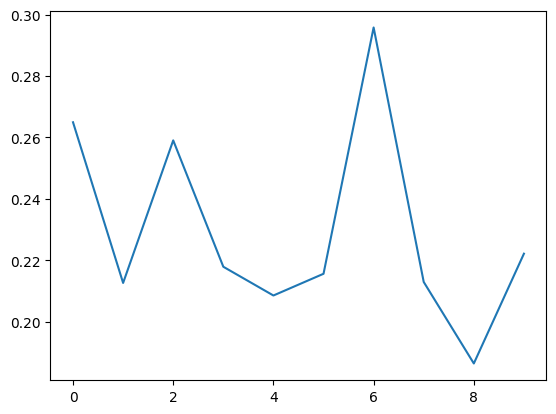

In [68]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses)

In [ ]:
"""
# Define the MSE loss function
criterion = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


num_epochs = 10
all_losses = []
losses_per_epoch = []

scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: min(1.0, (epoch + 1) / (0.1 * num_epochs)))

print("Iniciando el entrenamiento...")

for epoch in range(num_epochs):
    loss = 0
    print("~ Epoch:", epoch+1)
    batch_num = 0
    for data in train_dataloader:
        
        input1, input2, target_similarity = data
        
        optimizer.zero_grad()

        output_similarity = model(input1, input2)
        
        # Convertir target_similarity al mismo tipo de dato que output_similarity
        target_similarity = target_similarity.to(output_similarity.dtype)

        loss = criterion(output_similarity, target_similarity)

        loss.backward()
        optimizer.step()

        scheduler.step()
        
        if batch_num % 300 == 0:
            print(f"Batch number:: {batch_num}")
            all_losses.append(loss.item())
        batch_num = batch_num + 1

    print(f"Epoch {epoch+1}, Loss: {loss.item()}, Learning Rate: {scheduler.get_last_lr()[0]}")
    losses_per_epoch.append(loss.item())
print("¡Fin del entrenamiento!")
"""